# Some pre experiments for my bachelor thesis


Let's do some pre experiments. We now have a look at the distibution of the weights during a single magnitude based pruning. I pruned away 90% of the weights in the pruning procedure. The network had the same accuracy as the previous one after 10 epochs of retraing

In [1]:
import pandas as pd
import seaborn as sns

Since the seaborn package currently uses some functions that will be changed in the future we get an error if we try to plot a distribution, so we don't show the future warnings any more since they don't affect the outcome of the plotting.

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Magnitude based pruning

Here we will compare the distribution of the weights before the pruning, after the pruning and after the retraining. In the beggining you can see that the weights are nearly gaussian distributed. After the single pruning of the top 90% of the weights we all the middle weights are eliminated as expected. Even after the retraining which reaches as satisfying performance as the previous network the distribution has dramatically changed. In contrast to this the weights are distributed nearly normal before the training process in the interval [-0.5, 0.5].

In [3]:
sns.set()
sns.set_context("paper")

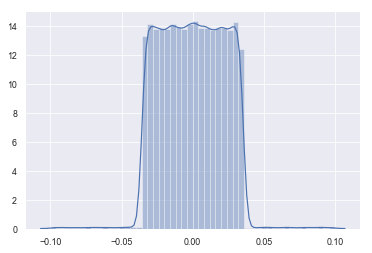

In [4]:
sns.distplot(pd.read_pickle('./results/magnitude_weight_distribution/untrained.pkl'))

Now the network is trained for 20 epochs on the MNIST dataset. The final network has a accuraccy of 97% approximatly. This means from 10,000 images 300 are missclassified while 9700 are correctly classified.

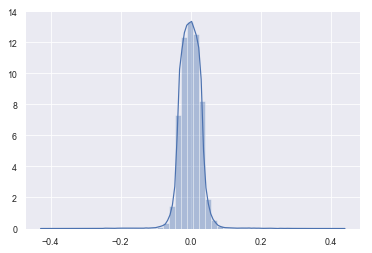

In [5]:
sns.distplot(pd.read_pickle('./results/magnitude_weight_distribution/unpruned.pkl'))

Now 90% of the weights from the network are set to 0. This is reflected in the next graph. As you can see the distribution has changed since no more small magnitude weights are available. The accuracy of the network drops around 10% to 88%.

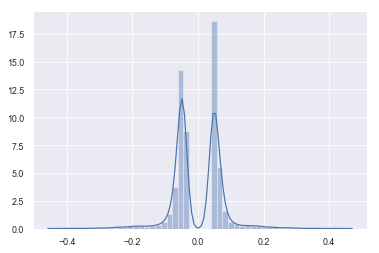

In [6]:
sns.distplot(pd.read_pickle('./results/magnitude_weight_distribution/pruned.pkl'))

After a retraining of 10 epochs the distribution of the network again reaches a performance of 97% just slightly less than the original one. But you have to keep in mind that the network now only has 10% of the parameters as the original one had. Furthermore the distribution of the network doesn't seem to be changed very much. Only a few weights have adopted and are now near zero. The majority still has a similar value as before.

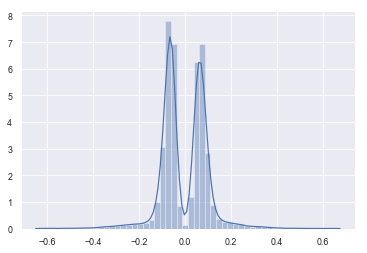

In [7]:
sns.distplot(pd.read_pickle('./results/magnitude_weight_distribution/retrained.pkl'))

## Random pruning

Now let's do some comparison on single random pruning and evaluate how retraining is going. The pruning procedure ran 6 times on the same fully connected model which has been pre-trained and then locally saved. Between 90% and 100% of the elements were pruned. As you would expect as more weights are pruned as worse is the outcoming network after retraining. Obviously this doesn't hold for the accuracy right after the pruning since these are completly random.

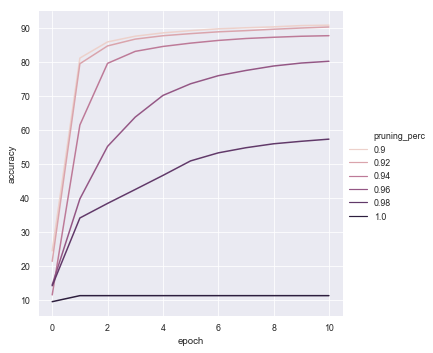

In [8]:
s = pd.read_pickle('./results/random_pruning_results/random_single_pruning.pkl')
plot = sns.relplot(x='epoch', y='accuracy', hue='pruning_perc', legend='full', kind="line", data=s, linewidth=1.5)

## A prunable pytorch model

The first step that needs to be done is to implement a pytorch model that allows use to delete several weights from the network. Therefore we use a Custom Layer which is a subclass of Linear Layer and instead of just calling the forward function we multiply a bit mask to the weights in this step. By changing a entry in the mask to zero this weight will no longer have influence on the output. Due to the multiplication during the backpropergation algorithm the gradient will be set to zero, since the derivative of a value times 0 is always zero. But let's see how it works:

First of all we will create a very small network that has 2 inputs, 2 hidden units and 2 outputs. Here we can easily calculate all gradients by hand to check if the implementation is correct. This will not be possible in bigger networks we will use later.

First of all import the stuff that we need from pytorch.

In [9]:
import torch
import torch.nn as nn
import numpy as np

Now we have all we need for now from the pytorch framework. The next thing we need is the implementation of the Prunable Layers. Therefore we need to import these from the actual implementation.

In [10]:
%run "pruning_nn\network.py"

Now we have included everything we need we can build our first small network. I called it MiniNet because it is rather small compared to the networks you normally use. Normally you wouldn't use fixed weights but in this case it makes sense because with this we have deterministic results for the backprop. algorithm and know how the network is looking exactly. In practive it is very important to use non dterministic start positions since these variations determine which local minimum can be reached.

In [11]:
class MiniNetwork(nn.Module):
    def __init__(self):
        super(MiniNetwork, self).__init__()
        # linear layer 1 with fixed weights
        self.l1 = MaskedLinearLayer(2, 2, bias=False)
        self.l1.weight.data = torch.Tensor([[0.5, 0.75], [0.25, 0.5]])
        # linear layer 2 with fixed weights
        self.l2 = MaskedLinearLayer(2, 2, bias=False)
        self.l2.weight.data = torch.Tensor([[0.15, 0.45], [0.5, 0.25]])
        # activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.l1(x)
        out = self.sigmoid(out)
        return self.l2(out)

Now let's put some data through the network and calculate it compared to a loss we made up. Obviously this data doesn't make sense but it is neccesary for math reasons :)

In [12]:
miniNet = MiniNetwork()
criterion = nn.MSELoss()

net_output = miniNet(torch.Tensor([1, 1]))
expected_output = torch.Tensor([0.3, 0.7])
print(get_network_weight_count(miniNet))

tensor(8.)


The actual outcome of the network is [0.422, 0.558] as you can easily verify by running the network. 
Now after we computed the actual outcome and made up the wanted outcome of the network we can calculate the overall loss of the network. Therefore we calculate the loss with the Mean Squared Error (MSE) where $y$ is the desired output and $\bar{y}$ is the actual outcome:
$$Loss = \frac{1}{n} \sum_{n \in N} (y - \bar{y})^2$$
Now we can just place the actual values and the desired values from above in the formula and as the result we get the loss of the network:
$$ Loss = \frac{1}{2} [(0.422-0.3)^2 + (0.558 - 0.7)^2] = 0.0175$$

In [13]:
loss = criterion(net_output, expected_output)
print('loss:', loss.data)

loss: tensor(0.0175)


As you can see the loss calculated is exactly the one we calculated by hand previously as we would expect it to be.

In the next step we create another Mini network but this time we delete one weight by setting it's mask value to zero during its inizialization. Another time we have to compute the loss which is exactly the same procedure as above, but obviously the values change due to the changed network structure. If we calculate the network outcome and afterwards the network loss we recive a total loss of 0.0100

In [14]:
class MiniNetwork2(nn.Module):
    def __init__(self):
        super(MiniNetwork2, self).__init__()
        # linear layer 1 with fixed weights
        self.l1 = MaskedLinearLayer(2, 2, bias=False)
        self.l1.weight.data = torch.Tensor([[0.5, 0.75], [0.25, 0.5]])
        # linear layer 2 with fixed weights
        self.l2 = MaskedLinearLayer(2, 2, bias=False)
        self.l2.weight.data = torch.Tensor([[0.15, 0.45], [0.5, 0.25]])
        # activation function
        self.sigmoid = nn.Sigmoid()
        # set one weight to zero
        mask = self.l2.get_mask()
        mask[0][0] = 0
        self.l2.set_mask(mask)

    def forward(self, x):
        out = self.l1(x)
        out = self.sigmoid(out)
        return self.l2(out)

    
miniNet2 = MiniNetwork2()
criterion2 = nn.MSELoss()
optimizer2 = torch.optim.SGD(miniNet.parameters(),
                            lr=0.1)

net_output2 = miniNet2(torch.Tensor([1, 1]))
expected_output2 = torch.Tensor([0.3, 0.7])
loss2 = criterion(net_output2, expected_output2)
print('output:', net_output2.data)
print('loss:', loss2.data)

output: tensor([0.3056, 0.5584])
loss: tensor(0.0100)


For the stocastic gradient descent algorithm we need the first derivative which can be computed pretty easy using the pytorch framework with the `loss.backward()` function. This function stores the information about the gradient in the tensors that are involved in the calculation of the loss. Since the loss is dertermined by the network output for each weight there will be a gradient calculated. Lets have a look at the weights that are directly connected to the output first.

The gradient of a weight $w_{i, j}^{(k)}$ is mathematically described as follows: $\frac{\partial E}{\partial w_{i, j}^{(k)}}$. This means weight w is connecting the node j of layer k to the node i of layer k+1. By E we denote the loss of the network.

In [15]:
loss2.backward()

In [16]:
print(miniNet2.l2.weight.grad)

tensor([[ 0.0000,  0.0038],
        [-0.1100, -0.0961]])


As you can see the gradient of the weight, which is masked remains zero, so during the optimizing process this weight will not be updated and therefore remain zero forever. This means the network behaves as if this weight doesn't exist. For the gradients of the hidden layer it is a bit more complicated, since the weight has influence on all parts of the error. But let's just start the same way we did above.

## Calculate the 2nd order derivative

For the pruning techniques like OBD and OBS we need not only the first order derivative but also the 2nd order in oder to approximate the change of the cost function by deleting the weight. Let's start with OBD. Here we need to calculate the diagonal of the Hessian Matrix for every weight. This means for every weight w we have to evaluate $\frac{\partial^2 E}{(\partial w )^2}$.

In [17]:
from torch.autograd import grad

In [18]:
net_output_2d = miniNet2(torch.Tensor([1, 1]))
expected_output_2d = torch.Tensor([0.3, 0.7])
loss_2d = criterion(net_output_2d, expected_output_2d)

weight_params = map(lambda x: x.get_weight(), get_single_pruning_layer(miniNet2))
loss_grads = grad(loss_2d, weight_params, create_graph=True)

Now we did compute the first order derivtive just as in the previous section. Now we must derivitate the 1st order again in order to otain the 2nd order derivative. Since we currently are only interested in the diagonal we don't have to compute very derivative but for $w = \frac{\partial E}{\partial w_{i, j}}$ we need to compute $\frac{\partial w}{\partial w_{i, j}}$.

In [19]:
for grd, layer in zip(loss_grads, get_single_pruning_layer(miniNet2)):
    all_grads = []
    mask = layer.get_mask().view(-1)

    for num, (g, m) in enumerate(zip(grd.view(-1), mask)):
        if m.item() == 0:
            all_grads += [0]
        else:
            drv = grad(g, layer.get_weight(), retain_graph=True)
            all_grads += [drv[0].view(-1)[num].item()]

    # set saliency
    # todo: use set saliency method instead!!
    layer.grad = torch.tensor(all_grads).view(layer.get_weight().size()) *  layer.get_weight().data.pow(2) *0.5
    print(layer.grad)

tensor([[0.0018, 0.0040],
        [0.0005, 0.0019]])
tensor([[0.0000, 0.0467],
        [0.0755, 0.0144]])


## Top k iterative pruning

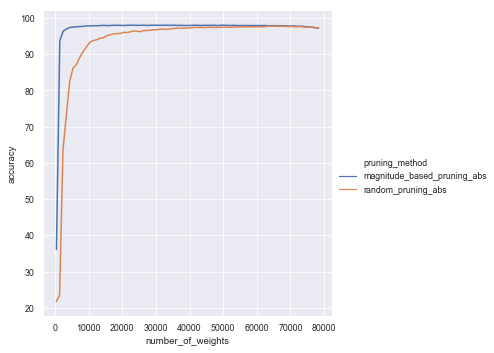

In [33]:
s = pd.read_pickle('./results/2018-12-10/magnitude_based_pruning_abs.pkl')
s2 = pd.read_pickle('./results/2018-12-10/random_pruning_abs.pkl')
s = s.append(s2)
plot = sns.relplot(x='number_of_weights', y='accuracy', hue='pruning_method', legend='full', kind="line", data=s, linewidth=1.5)

These results are from top 1000 elements pruning with 2 retraining epochs between each of the pruning steps. The network originally had 79400 elements therfore 79 pruning iterations could be done. 

Magnitude:
The result network only had 400 weights and therefore the accuracy dropped to 36%. The original network was trained for 20 epochs and had a accuracy of ?? TODO percent. The highest accuracy is reached after step 56 in which the network has an accuracy of 98%, which is a little better than the original network due to overfitting.

Random:
Due to rounding errors the network was actually smaller than intended. In some steps not 1000 but 1001 elements have een pruned. Never the less you can see that the network performs way worse if random pruning is used instead of magnitude ased pruning.

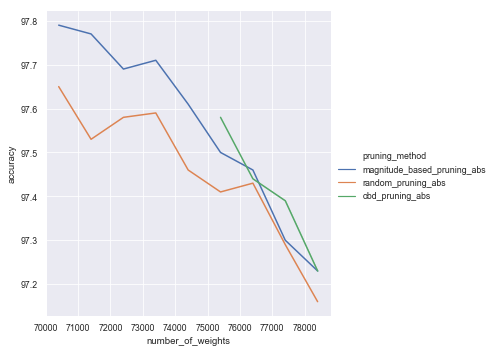

In [36]:
s3 = pd.read_pickle('./results/2018-12-13/obd_pruning_abs.pkl')
s = s.append(s3)
s = s.loc[s['number_of_weights'] > 70000]
plot = sns.relplot(x='number_of_weights', y='accuracy', hue='pruning_method', legend='full', kind="line", data=s, linewidth=1.5)

## Pruning Algorithms

Now we can implement the pruning algorithms. In this sheet we will implement 6 different strategies. Two of them are based on the general network and the other 4 are top down strategies, meaning their caluculations are based on the network outout. The strategies are:
- Random Pruning
- Magnitude Based Pruning
- OBD
- OBS
- Net-Trim
- Layerwise OBS

There are several ways to prune in a network the two main approaches are ``iterative pruning`` and ``single pruning``. 

In iterative pruning in each step either the ``top-k elements``, the ``top-p percentage`` or up to a specific threshold of the sum (``bucket``) is pruned. After the pruning procedure there is a retraining of two epochs with the stocastic gradient descent with a batch size of 64 images. 

In single pruning only one time is pruned therefore with a longer retraining phase. Normaly we use here 10 epochs for retraining but stop after one pruning procedure. For single pruning we can prune in a ``top-k elements`` way or up to a ``bucket`` as well. Again we retrain with stacastic gradient descent and a batch size of 64 images.